### Case Study

Continuation on from the previous notebook, we are now going to take a very basic moving average cross-over strategy and see if we can improve upon the returns by selecting only favourable HMM states which are generated as out-of-sample data for maximum caution.

We will also see how a quick backtest can be constructed and Equity curves along with Sharpe Ratios etc created.

### Imports

### Structure Data

In [1]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pyhhmm.gaussian import GaussianHMM

import matplotlib.pyplot as plt   

import yfinance

In [3]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-1"
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "OLECTRA.NS"
data = yfinance.download (tickers = stock_name,start="2005-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

data.tail()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-06-30,960.500000,1006.849976,960.000000,972.200012,3398740
2023-07-03,980.000000,999.000000,958.150024,988.000000,1829257
2023-07-04,998.000000,1007.650024,975.000000,989.450012,1626222
2023-07-05,991.500000,996.000000,976.500000,988.450012,1320942
2023-07-06,989.900024,1077.000000,985.099976,1044.400024,6961886


In [4]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  4524


,Open,High,Low,Close,Volume,Returns,Range
Date,,,,,,,
2005-03-08,17.158432,17.204805,14.097738,17.204805,607700,0.100890,0.220395
2005-03-09,18.132288,18.735153,15.488964,17.668547,406600,0.026954,0.209581
2005-03-10,17.622173,18.178663,16.926561,17.854044,150258,0.010499,0.073973
2005-03-11,17.622175,19.662638,17.204807,19.662638,236300,0.101299,0.142857
2005-03-14,20.358248,20.358248,18.688778,18.688778,41100,-0.049528,0.089330


In [5]:
# Add Moving Average
df["MA_12"] = df["Close"].rolling(window=12).mean()
df["MA_21"] = df["Close"].rolling(window=21).mean()

In [6]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  4024
X_train From:  2005-03-08 00:00:00
X_train To:  2007-03-12 00:00:00
X_test From:  2007-03-13 00:00:00
X_test To:  2023-07-06 00:00:00


### Train HMM

In [7]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 1, 1, 1, 2, 3, 0, 3, 0, 3], dtype=int32)

In [8]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2007-03-13,20.636496,20.636496,9800,0.052010,0.000000,18.321650,19.289434,1
2007-03-14,21.610350,21.703098,218400,0.051685,0.106383,18.592166,19.265143,1
2007-03-15,22.723326,21.610346,54400,-0.004274,0.088889,18.808578,19.289434,2
2007-03-16,22.027716,20.543743,20300,-0.049356,0.072235,19.009533,19.302684,0
2007-03-19,20.543741,21.610346,47900,0.051919,0.106888,19.338016,19.318142,3


### Run Backtest

In [10]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [11]:
# Add HMM Signals
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [12]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [13]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [14]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [15]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2023-06-28,952.299988,952.299988,0,0.000000,0.000000,940.241664,874.785708,0,1.0,1,0.0,0.000000,3.831819,45.146400,0.000000,6.691787,804.761201
2023-06-30,960.500000,972.200012,3398740,0.020897,0.048802,945.524999,886.095232,3,1.0,0,1.0,0.020681,3.852500,46.110713,0.020099,6.711886,821.119705
2023-07-03,980.000000,988.000000,1829257,0.016252,0.042634,951.662501,896.866661,0,1.0,1,0.0,0.016121,3.868622,46.876346,0.000000,6.711886,821.119705
2023-07-04,998.000000,989.450012,1626222,0.001468,0.033487,954.591670,907.326186,3,1.0,0,1.0,0.001467,3.870088,46.946610,-0.006534,6.705352,815.765218
2023-07-05,991.500000,988.450012,1320942,-0.001011,0.019969,959.779170,916.690473,0,1.0,1,0.0,-0.001011,3.869077,46.898152,-0.000000,6.705352,815.765218


### Calculate Metrics

In [16]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [17]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [18]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 4689.8%
Returns Strategy: 81576.5%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.43
Sharpe Strategy: 1.08


### Plot Results

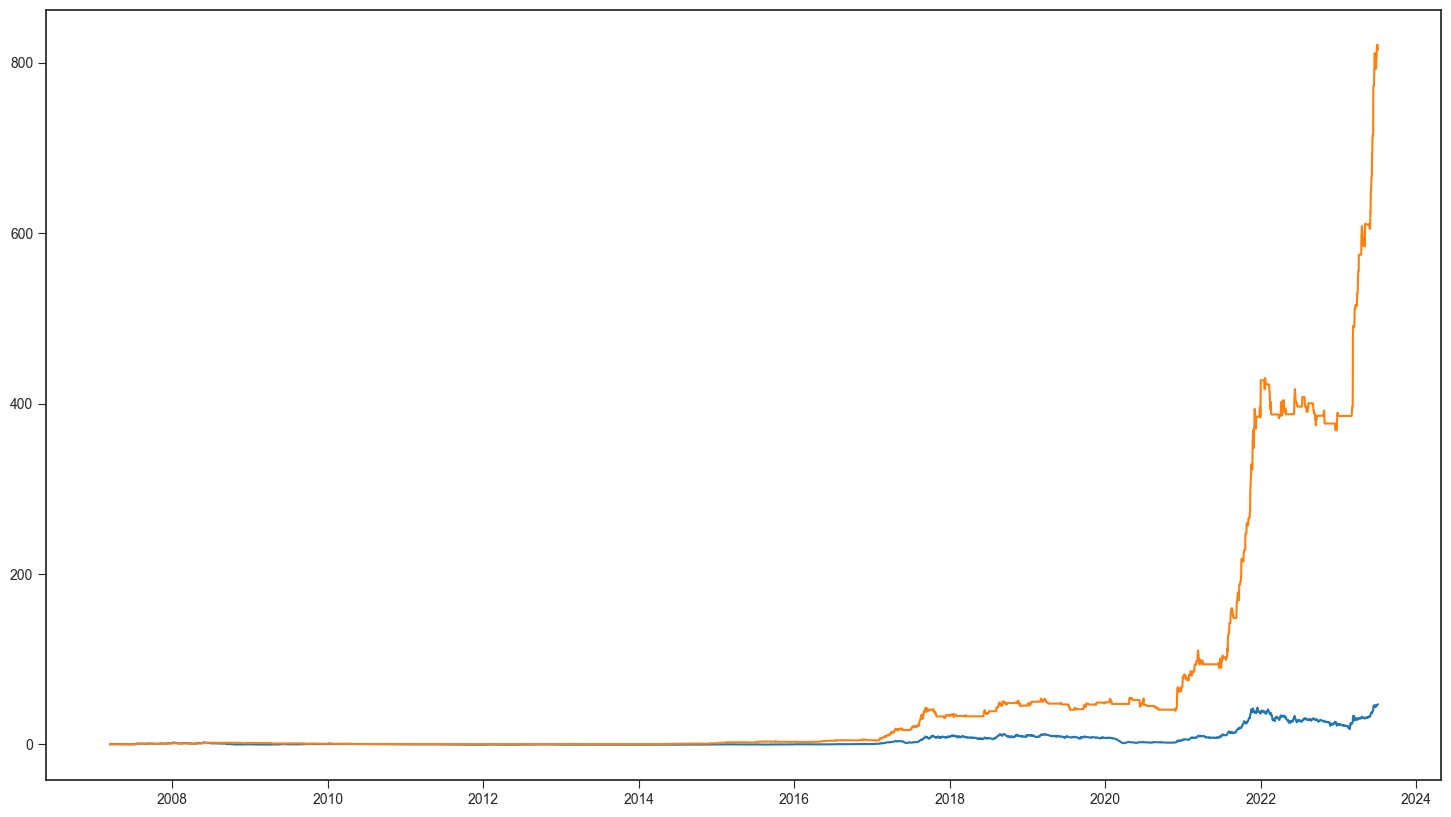

In [19]:
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()

### Save Data

In [18]:
# Save Data
df_main.to_csv("data/HMM-SPY.csv")

### Conclusion

It is clear that the moving average cross-over strategy performs vastly better in both returns and Sharpe Ratio, when trading only in favourable hidden states determined by the Hidden Markov Model unsupervised learning method.

CAUTION: Backtesting is fraught with areas of inconsitency. The price assumptions made in our strategy for backtesting are highly unlikely going to be like prices based on a real trading environment. "Backtesting is not a research tool. Feature Importance is". - Marcos Lopez De Prado (Author of Advances in Financial Machine Learning).